In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary

In [576]:
from models.resnext import ResNextpp
from models.score_base import ScoreModel
from configs import mnist_config, mnist_small_config

In [804]:
config = mnist_small_config.get_config()
workdir = "workdir/mnist/nf32/Adam"
ckpt_dir = os.path.join(workdir,"checkpoints-meta", "last.ckpt")
net = ResNextpp(config)
scorenet = ScoreModel.load_from_checkpoint(checkpoint_path=ckpt_dir,
                                        config=config, net=net).cuda()
scorenet
scorenet.eval()

ScoreModel(
  (net): ResNextpp(
    (proj): GaussianFourierProjection()
    (dense): Linear(in_features=64, out_features=128, bias=True)
    (film1): FiLMBlock(
      (dense): Linear(in_features=128, out_features=64, bias=True)
    )
    (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (blocks): ModuleList(
      (0): ResNeXtBlock(
        (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (norm3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (norm4): InstanceNorm2d(32, eps=1e-05, momentum

In [805]:
%%time
num_scales = config.model.num_scales
c,h,w = config.data.num_categories, config.data.image_size, config.data.image_size
N=8
x,t = torch.zeros(N,c,h,w, device="cuda"), torch.randint(1, size=(N,), device="cuda")
scores = scorenet(x,t).detach().cpu()
scores.shape

CPU times: user 6.11 ms, sys: 3 µs, total: 6.11 ms
Wall time: 5.43 ms


torch.Size([8, 3, 28, 28])

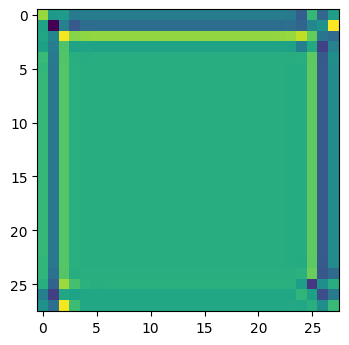

In [806]:
plt.imshow(scores[0,0])

In [807]:
from torchvision.utils import make_grid
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.dpi"] = 100

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        # print(np.asarray(img).shape)
        axs[0, i].imshow(np.asarray(img[0]), cmap="viridis")
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def show_imgs(x, argmax=True):
    if argmax:
        x_fig = torch.argmax(x, dim=1, keepdim=True)
    else:
        assert x.shape[1] in [1,3], "Image channels must either be Grayscale or RGB"
        x_fig = x
    grid = make_grid(x_fig)
    show(grid)

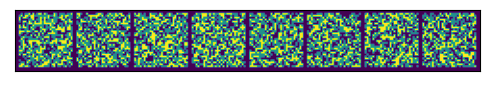

In [808]:
from models.mutils import prob_to_logit, log_concrete_sample, get_taus
# torch.manual_seed(42)
taus = torch.Tensor(get_taus(config))
x_uniform = log_concrete_sample(torch.ones(N, c, h, w), tau=taus[0])
show_imgs(x_uniform.cpu())

In [809]:
x.shape

torch.Size([8, 3, 28, 28])

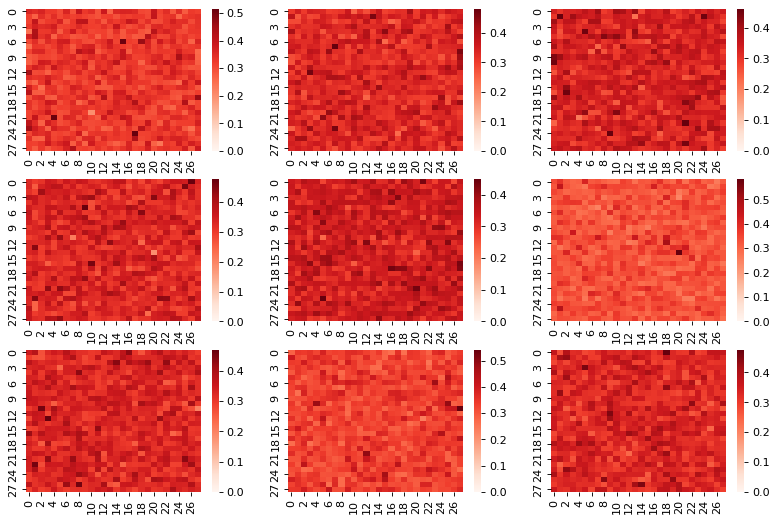

In [810]:
x = x_uniform.cpu()
fig, axs = plt.subplots(3, c, figsize=(12,8), dpi=80)
for i in range(c):
  sns.heatmap(x[0,i].exp(), ax=axs[0,i], vmin=0.0, vmax=None, cmap="Reds")
  sns.heatmap(x[1,i].exp(), ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(x[2,i].exp(), ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")

### Without noise

In [811]:
%%time
with torch.no_grad():
  x_sample = x_uniform.clone().cuda()
  for i in range(50):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    t=torch.ones(N, device="cuda") * 0
    s = scorenet(x_sample, t)
    x_sample = x_sample + s * 3e-1

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    lse = torch.logsumexp(x_sample, dim=1, keepdims=True)
    pixel_mask = (lse.abs() > 1e-10).float()
    x_sample -= lse * pixel_mask

x_sample.shape

CPU times: user 159 ms, sys: 697 µs, total: 160 ms
Wall time: 159 ms


torch.Size([8, 3, 28, 28])

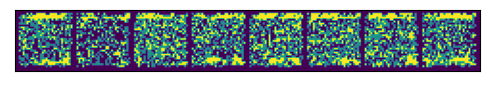

In [812]:
show_imgs(x_sample.cpu())

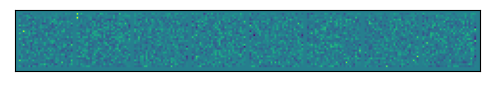

In [813]:
grid = make_grid(lse.cpu())
show(grid)

### With noise injection

CPU times: user 333 ms, sys: 0 ns, total: 333 ms
Wall time: 332 ms


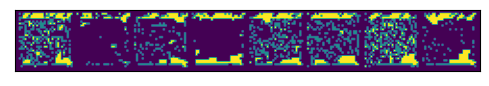

In [824]:
%%time
with torch.no_grad():
  x_sample = x_uniform.clone().cuda()
  for i in range(100):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    t=torch.ones(N, device="cuda") * 0
    s = scorenet(x_sample, t)
    noise = torch.randn_like(s[:,:1,:,:], device="cuda")

    x_sample = x_sample + s * 3e-1 + noise * 1e-2

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    lse = torch.logsumexp(x_sample, dim=1, keepdims=True)
    pixel_mask = (lse.abs() > 1e-3).float()
    x_sample -= lse * pixel_mask
    
    # if i % 10 == 0:
    #     smean = s.mean(1, keepdim=True).cpu()
    #     show_imgs(x_sample.cpu())
    #     show_imgs(smean, argmax=False)

show_imgs(x_sample.cpu())

In [816]:
noise.shape

torch.Size([8, 1, 28, 28])

In [817]:
# torch.linalg.norm?

In [821]:
smean = torch.linalg.norm(s.cpu(), dim=1)
smean.shape

torch.Size([8, 28, 28])

<AxesSubplot:>

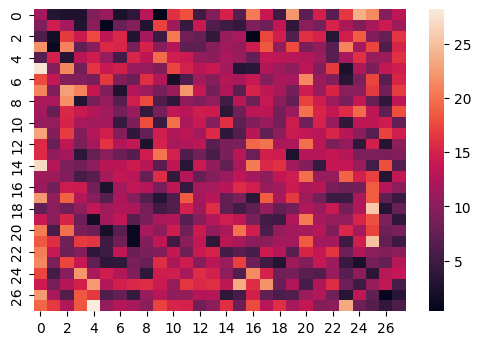

In [822]:
sns.heatmap(smean[0])

In [469]:
# sns.heatmap(x_sample[0,0].cpu())
sns.heatmap(x_uniform[0,0].cpu())

In [ ]:
show_imgs(smean, argmax=False)

### Langeniv Dynamics - kinda

In [ ]:
taus

In [ ]:
(taus/taus[-1])**2

In [883]:
@torch.no_grad()
def anneal_Langevin_dynamics(x_mod, scorenet, sigmas, n_steps_each=200, step_lr=0.000008,
                             final_only=False, verbose=False, denoise=False, lse_norm=False):
    images = []
    # torch.manual_seed(42)
    with torch.no_grad():
        for c, sigma in enumerate(sigmas):
            labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
            labels = labels.long()
            step_size = torch.tensor(step_lr) * (sigma / sigmas[-1]) ** 2
            # print(step_size)
            for s in range(n_steps_each):
                grad = scorenet(x_mod, labels)

                noise = torch.randn_like(x_mod, device="cuda") #* sigma
                x_mod = x_mod + step_size * grad + noise * torch.sqrt(step_size * 2).cuda()
                
            if lse_norm:
                # Small hack to normalize logits back to conform with
                # concrete distribution as it expects LSE to be zero ideally
                lse = torch.logsumexp(x_mod, dim=1, keepdims=True)
                pixel_mask = (lse.abs() > 1e-2).float()
                x_mod -= lse * pixel_mask

            if not final_only:
                images.append(x_mod.to('cpu'))
        
        if denoise:
            last_noise = (len(sigmas) - 1) * torch.ones(x_mod.shape[0], device=x_mod.device)
            last_noise = last_noise.long()
            x_mod = x_mod + sigmas[-1] ** 2 * scorenet(x_mod, last_noise)
            images.append(x_mod.to('cpu'))

        if final_only:
            return [x_mod.to('cpu')]
        else:
            return images
        


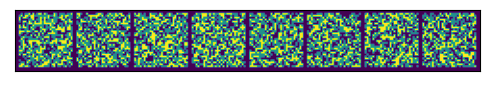

In [826]:
show_imgs(x_uniform.cpu())

CPU times: user 334 ms, sys: 43.9 ms, total: 378 ms
Wall time: 376 ms


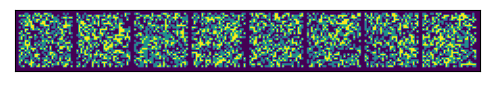

In [827]:
%%time
x_samples = anneal_Langevin_dynamics(x_uniform.cuda(), scorenet, taus, n_steps_each=20, step_lr=1e-3)
show_imgs(x_samples[-1])

In [603]:
taus

tensor([10.0000,  6.6874,  4.4721,  2.9907,  2.0000])

CPU times: user 3.08 s, sys: 281 ms, total: 3.37 s
Wall time: 3.37 s


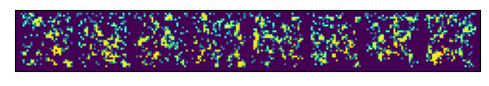

In [886]:
%%time
x_samples = anneal_Langevin_dynamics(x_uniform.cuda(), scorenet, taus, n_steps_each=200, step_lr=8e-4, lse_norm=True)
show_imgs(x_samples[-1])

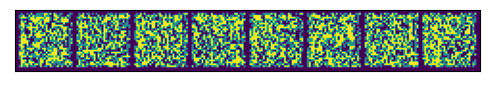

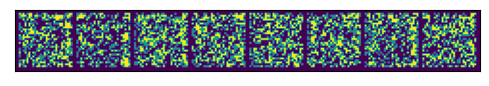

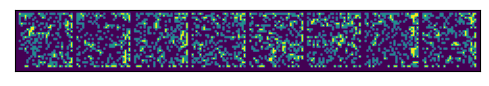

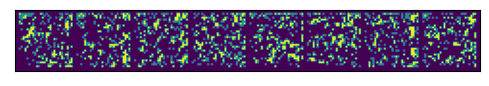

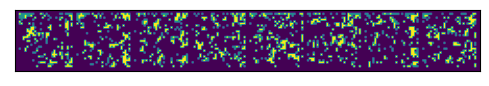

In [830]:
for i in range(len(x_samples)):
    show_imgs(x_samples[i])

In [403]:
config.eval

In [834]:
from dataloader import get_dataset
config.eval.batch_size=8
train_ds, val_ds = get_dataset(config)
mnist_sample, y = next(iter(val_ds))
mnist_sample.shape

torch.Size([8, 3, 28, 28])

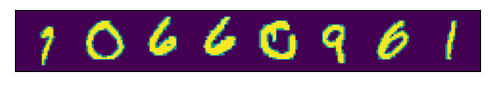

In [835]:
show_imgs(mnist_sample)

<AxesSubplot:>

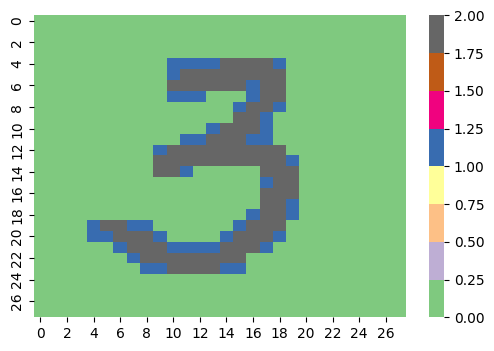

In [611]:
img = prob_to_logit(mnist_sample)
sns.heatmap(img.argmax(dim=1)[1], cmap="Accent")

In [836]:
def log_concrete_sample(class_logits: torch.Tensor, tau: torch.Tensor) -> torch.Tensor:
    eps = 1e-20
    U = torch.rand_like(class_logits)
    gumbel_samples = -torch.log(-torch.log(U + eps) + eps)

    x = (gumbel_samples + class_logits) / tau
    x = x - torch.logsumexp(x, dim=1, keepdim=True)
    # x = x - torch.logsumexp(x, dim=1, keepdim=True)
    return x

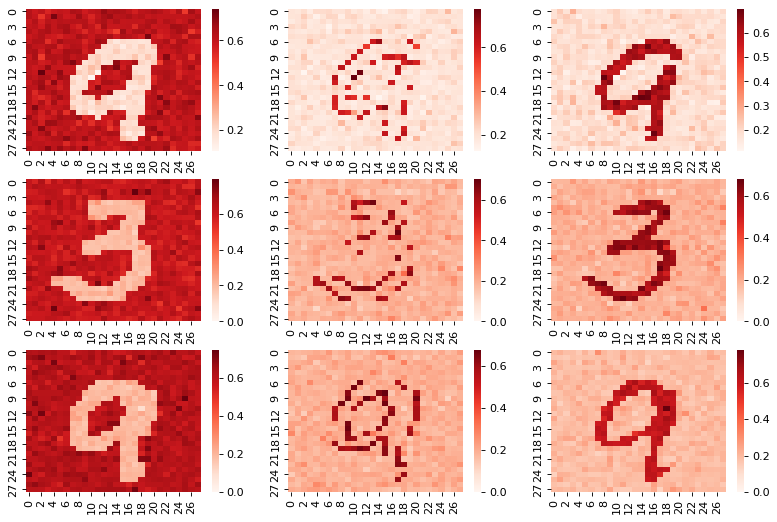

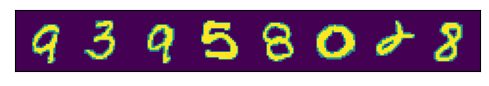

In [841]:
x = log_concrete_sample(img, tau=10)
fig, axs = plt.subplots(3, c, figsize=(12,8), dpi=80)
for i in range(c):
  sns.heatmap(x[0,i].exp(), ax=axs[0,i], cmap="Reds")
  sns.heatmap(x[1,i].exp(), ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(x[2,i].exp(), ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")

show_imgs(x)

In [839]:
x[0].exp().sum(0)[14:18,14:18]

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])

<AxesSubplot:>

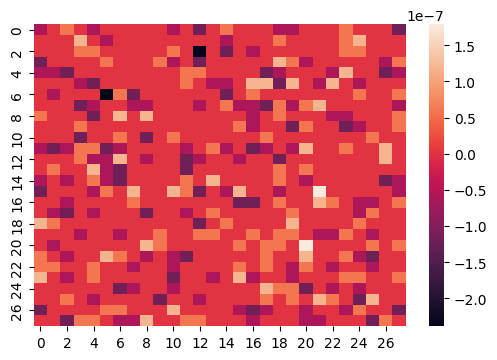

In [840]:
sns.heatmap(torch.logsumexp(x[3],dim=0).cpu())

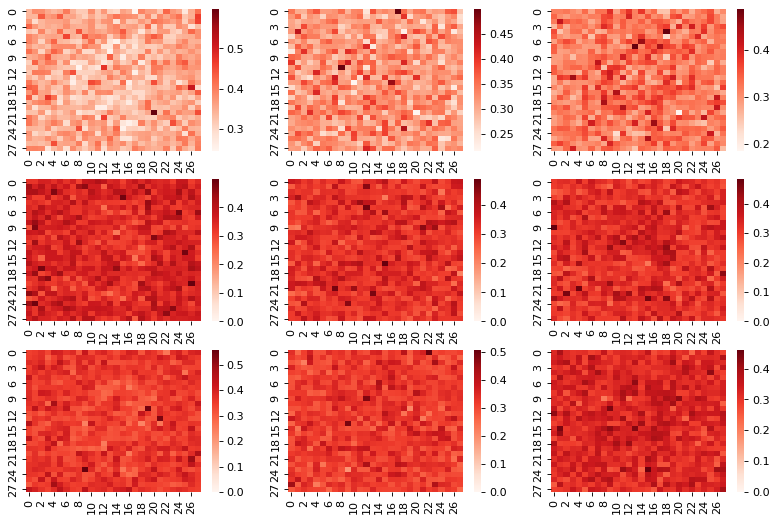

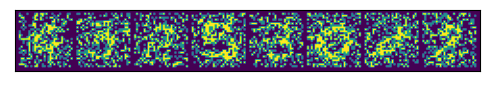

In [842]:
x = log_concrete_sample(img/10, tau=10)
fig, axs = plt.subplots(3, c, figsize=(12,8), dpi=80)
for i in range(c):
  sns.heatmap(x[0,i].exp(), ax=axs[0,i], cmap="Reds")
  sns.heatmap(x[1,i].exp(), ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(x[2,i].exp(), ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")

show_imgs(x)

CPU times: user 3.08 s, sys: 354 ms, total: 3.43 s
Wall time: 3.43 s


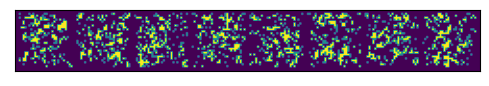

In [880]:
%%time
x_samples = anneal_Langevin_dynamics(x.cuda(), scorenet, taus, n_steps_each=200, step_lr=5e-4, lse_norm=True)
show_imgs(x_samples[-1])

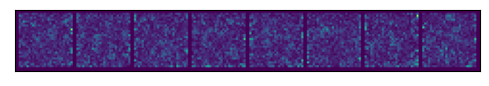

In [779]:
show_imgs((x-x_samples[-1]).abs().mean(1, keepdim=True), argmax=False)

CPU times: user 172 ms, sys: 831 µs, total: 173 ms
Wall time: 172 ms


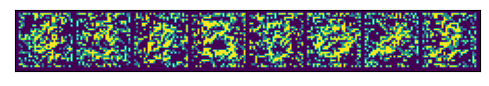

In [859]:
%%time
with torch.no_grad():
  x_sample = x.clone().cuda()
  for i in range(50):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    t=torch.ones(N, device="cuda") * num_scales
    s = scorenet(x_sample, t)
    noise = torch.randn_like(s[:,:1,:,:], device="cuda")

    x_sample = x_sample + s * 1e-3 #+ noise * 1e-2

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    # lse = torch.logsumexp(x_sample, dim=1, keepdims=True)
    # pixel_mask = (lse.abs() > 1e-3).float()
    # x_sample -= lse * pixel_mask

show_imgs(x_sample.cpu())

CPU times: user 182 ms, sys: 1.45 ms, total: 184 ms
Wall time: 182 ms


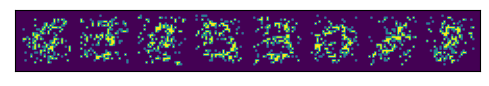

In [870]:
%%time
with torch.no_grad():
  x_sample = x.clone().cuda()
  for i in range(50):
    # print(torch.logsumexp(x_denoised, dim=1).mean())
    t=torch.ones(N, device="cuda") * 0
    s = scorenet(x_sample, t)
    noise = torch.randn_like(s[:,:1,:,:], device="cuda")

    x_sample = x_sample + s * 1e-3 #+ noise * 5e-4

    # Small hack to normalize logits back to conform with
    # concrete distribution as it expects LSE to be zero ideally
    lse = torch.logsumexp(x_sample, dim=1, keepdims=True)
    pixel_mask = (lse.abs() > 1e-3).float()
    x_sample -= lse * pixel_mask

show_imgs(x_sample.cpu())

In [451]:
x = log_concrete_sample(img, tau=20)
fig, axs = plt.subplots(3, c, figsize=(12,8), dpi=80)
for i in range(c):
  sns.heatmap(x[0,i].exp(), ax=axs[0,i], vmin=0.0, cmap="Reds")
  sns.heatmap(x[1,i].exp(), ax=axs[1,i], vmin=0.0, cmap="Reds")
  sns.heatmap(x[2,i].exp(), ax=axs[2,i], vmin=0.0, vmax=None, cmap="Reds")